In [6]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape # torch.Size([1500, 5])


torch.Size([1500, 5])

**小批量梯度下降优化算法**

In [2]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

**训练函数**

In [7]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = linreg, squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

In [8]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

In [9]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

loss: 0.243530, 0.046884 sec per epoch


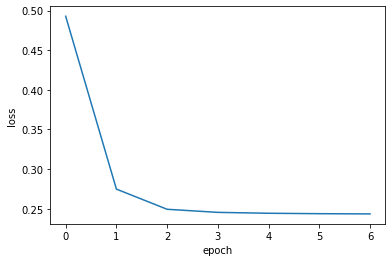

In [10]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

**简洁实现**

In [13]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

loss: 0.243828, 0.062515 sec per epoch


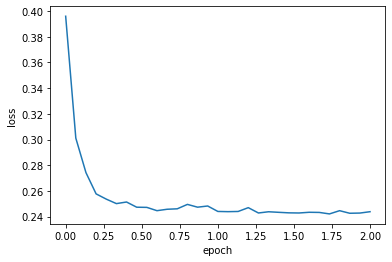

In [14]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)

loss: 0.244196, 0.045657 sec per epoch


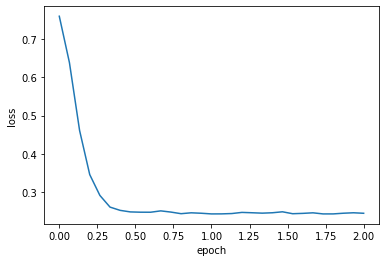

In [15]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)